# NELDER-MEAD METHOD

## 2-D Implementation

In [2]:
import numpy as np


def sort_state(state, fun):
    xs = np.array([state["best"], state["lousy"], state["worst"]])
    fs = np.array([fun(xs[0]), fun(xs[1]), fun(xs[2])])
    ind = np.argsort(fs)
    state["best"] = xs[ind[0]]
    state["lousy"] = xs[ind[1]]
    state["worst"] = xs[ind[2]]

    return state


def shrink(state, fun):
    state["lousy"] = 0.5 * (state["best"] + state["lousy"])
    state["worst"] = 0.5 * (state["best"] + state["worst"])

    return sort_state(state, fun)


def nelder_mead2d(fun, x1, x2, x3,
                   const_x_R = 2, const_x_E = 3,
                     eps_step = 0.01, eps_fun = 0.01,n_iter = 1000):

    states = []

    # Assign classes to the initial 3 points
    state = {"best": x1, "lousy": x2, "worst": x3}
    state = sort_state(state, fun)

    
    # Apply Nelder-Mead iterations
    for i in range(n_iter):

        # Save each state
        states.append(state.copy())

        # Calculate XR and XE
        x_average = 0.5 * (state["best"] + state["lousy"])
    
        x_R =  state["worst"] + const_x_R * (x_average - state["worst"])
        x_E = state["worst"] +  const_x_E * (x_average - state["worst"])
        
        # Condition 1
        y_R = fun(x_R)
        y_E = fun(x_E)
 
        if y_R < fun(state["best"]):
            # Update with x_E or x_R
            state["worst"] = state["lousy"]
            state["lousy"] = state["best"]
            if y_E < y_R:
                state["best"] = x_E

            else:
                state["best"] = x_R

        # Condition 2
        elif y_R < fun(state["lousy"]):
  
            state["worst"] = state["lousy"]
            state["lousy"] = x_R

        
        # Condition 3
        elif y_R < fun(state["worst"]):
            
            x_oc = state["worst"] + 3/2 * (x_average - state["worst"])
            y_oc = fun(x_oc)
            if y_oc < y_R:
                state["worst"] = x_oc

            # Else shrink
            else:   
                state = shrink(state, fun)

        # Condition 4
        else:
            
            x_ic = state["worst"] + 1/2 * (x_average - state["worst"])
            y_ic = fun(x_ic)
            if y_ic < fun(state["worst"]):
                state["worst"] = x_ic
                state = sort_state(state, fun)
            else:
                state = shrink(state, fun)


        # Convergence
        max_len = np.max([np.linalg.norm(state["best"] - state["worst"])])
                          #np.linalg.norm(state["lousy"] - state["worst"]),
                          # np.linalg.norm(state["best"] - state["lousy"])])
        
        fun_dif = fun(state["best"]) - fun(state["worst"])
        if (fun_dif < eps_fun and max_len < eps_step):
            print(i)
            return states

    return states


## Generalized to arbitrary dimensions

In [15]:
from tqdm import tqdm

def sort_points_and_vals(points, fun_vals):
    ind = np.argsort(fun_vals)
    points = np.array(points)[ind]
    fun_vals = np.array(fun_vals)[ind]
    return list(points), list(fun_vals)


def shrink_gen(points, fun_vals, fun):
    for i, point in enumerate(points[1:]):
        points[i] = 0.5 * (points[0] + point)
        fun_vals[i] = fun(points[i])
    
    return sort_points_and_vals(list(points), list(fun_vals))


def nelder_mead(fun, x_start, 
                const_x_R = 2, const_x_E = 3, start_point_r = 2,
                     eps_step = 0.01, eps_fun = 0.01,n_iter = 10):
    # Saving the best point in each step
    best_points = []

    # Initialize the first collection of points == dim + 1
    points = []
    fun_vals = []
    points.append(x_start)
    fun_vals.append(fun(x_start))


    for i in range(len(x_start)):
        new_point = x_start.copy()

        # Change each point a bit
        new_point[i] += start_point_r
        points.append(new_point)
        fun_vals.append(fun(new_point))

    print(points)

    points, fun_vals = sort_points_and_vals(points, fun_vals)

    # Nelder mead iterations
    for i in tqdm(range(n_iter)):

        # Save the best point
        best_points.append(points[0])
        
        # Calculate XR and XE
        x_average = np.mean(points[:-1], axis=0) # all but the worst point

        x_R = points[-1] + const_x_R * (x_average - points[-1])
        x_E = points[-1] + const_x_E * (x_average - points[-1])

        # Condition 1
        y_R = fun(x_R)
        y_E = fun(x_E)

        if y_R < fun_vals[0]:

            # Update with x_E or x_R
            points.pop(-1)
            fun_vals.pop(-1)

            if y_E < y_R:
                points.insert(0, x_E)
                fun_vals.insert(0, y_E)
            else:
                points.insert(0, x_R)
                fun_vals.insert(0, y_R)

        # Condition 2
        elif y_R < fun_vals[-2]:

            points[-1] = x_R
            fun_vals[-1] = y_R
            points, fun_vals = sort_points_and_vals(points, fun_vals)

        # Condition 3
        elif y_R < fun_vals[-1]:
            
            x_oc = points[-1] + 3/2 * (x_average - points[-1])
            y_oc = fun(x_oc)
            if y_oc < y_R:
                points[-1] = x_oc
                fun_vals[-1] = y_oc

            # Else shrink
            else:
                points, fun_vals = shrink_gen(points, fun_vals, fun)

        # Condition 4
        else:
            x_ic = points[-1] + 1/2 * (x_average - points[-1])
            y_ic = fun(x_ic)
            if y_ic < fun_vals[-1]:
                points[-1] = x_ic
                fun_vals[-1] = y_ic 
                points, fun_vals = sort_points_and_vals(points, fun_vals)

            else:
                points, fun_vals = shrink_gen(points, fun_vals, fun)

        # Convergence
        max_len = np.linalg.norm(points[0] - points[-1])
        fun_diff = fun_vals[0] - fun_vals[-1]

        if(fun_diff < eps_fun and max_len < eps_step):
            print(f"Converged in {i} steps")
            return best_points

    return best_points


### Test on a simple 2-d function

48


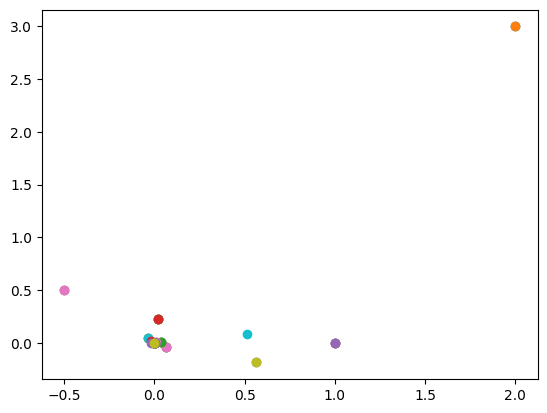

[[2, 3], [4, 3], [2, 5]]


 96%|█████████▌| 48/50 [00:00<?, ?it/s]

Converged in 48 steps


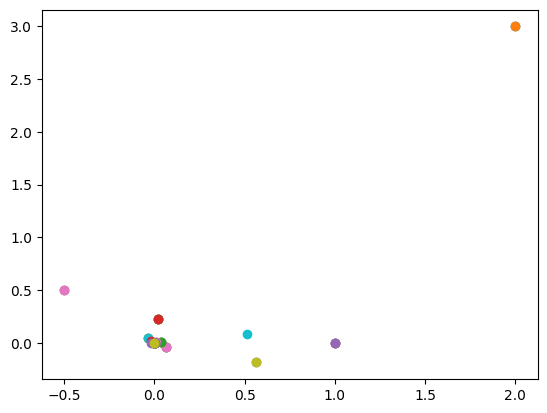

In [17]:
import matplotlib.pyplot as plt

def f(x):
    return x[0]**2 + x[1]**2

# # With 2D implementation
states = nelder_mead2d(f, [2,3], [4,3], [2,5], n_iter=50, eps_step=0.0001, eps_fun=10)
 
alpha = 1
for i, state in enumerate(states):
    # plt.scatter([state["best"][0], state["lousy"][0], state["worst"][0]],[state["best"][1], state["lousy"][1], state["worst"][1]], alpha=alpha)
    plt.scatter([state["best"][0]],[state["best"][1]], alpha=alpha)

plt.savefig("report/figures/convergence_2d.png")
plt.show()


# With the general 
best_points = nelder_mead(f, [2,3], n_iter=50,  eps_step=0.0001, eps_fun=10)

plt.figure()
for point in best_points:
    plt.scatter(point[0], point[1])
plt.savefig("report/figures/convergence_alld.png")
    

## Use nelder mead on the 3 functions

In [4]:
# Function 1
def f1(x):
    return (x[0] - x[2])**2 + (2*x[1] + x[2])**2 + (4*x[0] - 2*x[1] + x[2])**2 + x[0] + x[1]

# Function 2 
def f2(x):
    return (x[0] - 1)**2 + (x[1] - 1)**2 + 100* (x[1] - x[0]**2)**2 + 100* (x[2] - x[1]**2)**2

# Function 3
def f3(x):
    return (1.5 - x[0] + x[0] * x[1])**2 + (2.25 - x[0] + x[0]*x[1]**2)**2 + (2.625 - x[0] + x[0] * x[1]**3)**2


In [5]:
# Function 1
start_point = [0,0,0]
best_points = nelder_mead(f1, start_point, n_iter=100000, eps_fun=1e-8, eps_step=1e-8, start_point_r=2)
print(f1(best_points[-1]), best_points[-1])

start_point = [1,1,0]
best_points = nelder_mead(f1, start_point, n_iter=100000, eps_fun=1e-8, eps_step=1e-8, start_point_r=2)
print(f1(best_points[-1]), best_points[-1])

  0%|          | 136/100000 [00:00<00:04, 22683.63it/s]


Converged in 136 steps
-0.1979166666666666 [-0.16666666 -0.22916666  0.16666667]


  0%|          | 131/100000 [00:00<00:03, 27257.36it/s]

Converged in 131 steps
-0.19791666666666505 [-0.16666667 -0.22916666  0.16666665]


In [6]:
# Function 2
start_point = [1.2,1.2,1.2]
best_points = nelder_mead(f2, start_point, n_iter=100000, eps_fun=1e-12, eps_step=1e-12)
print(f2(best_points[-1]), best_points[-1])

start_point =  [-1,1.2,1.2]
best_points = nelder_mead(f2, start_point, n_iter=100000, eps_fun=1e-8, eps_step=1e-8)
print(f2(best_points[-1]), best_points[-1])

  0%|          | 240/100000 [00:00<00:03, 25073.05it/s]


Converged in 240 steps
1.0092555322575939e-23 [1. 1. 1.]


  0%|          | 124/100000 [00:00<00:04, 20177.44it/s]

Converged in 124 steps
0.2462649477117873 [0.75411765 0.56933541 0.32242928]


In [7]:
# Function 3
start_point = [1,1]
best_points = nelder_mead(f3, start_point, n_iter=100000, eps_fun=0.0001, eps_step=0.0001, start_point_r=2)
print(f3(best_points[-1]), best_points[-1])

start_point = [4.5,4.5]
best_points = nelder_mead(f3, start_point, n_iter=100000, eps_fun=0.0001, eps_step=0.0001, start_point_r=2)
print(f3(best_points[-1]), best_points[-1])

  0%|          | 38/100000 [00:00<00:04, 22127.38it/s]


Converged in 38 steps
1.0017994456440688e-08 [2.99975658 0.49994443]


  0%|          | 69/100000 [00:00<00:07, 13800.34it/s]

Converged in 69 steps
1.0723743682286354e-08 [2.99974765 0.49993263]


## Using Nelder Mead on the blackbox functions

In [8]:
import os
import subprocess

env = os.environ.copy()
env["PATH"] += r";C:\mysys64\usr\bin"

def blackbox1(x):
    result = subprocess.run(
        ["./hw4_1_win.exe", "63240454", "1", f"{x[0]}", f"{x[1]}", f"{x[2]}"],
        capture_output=True,
        text=True,
        env=env
    )
    return float(result.stdout)


def blackbox2(x):
    result = subprocess.run(
        ["./hw4_1_win.exe", "63240454", "2", f"{x[0]}", f"{x[1]}", f"{x[2]}"],
        capture_output=True,
        text=True,
        env=env
    )
    return float(result.stdout)


def blackbox3(x):
    result = subprocess.run(
        ["./hw4_1_win.exe", "63240454", "3", f"{x[0]}", f"{x[1]}", f"{x[2]}"],
        capture_output=True,
        text=True,
        env=env
    )
    return float(result.stdout)

### Function 1

In [ ]:
# Function 1
start_point = [-1,1.2,1.2]
best_points = nelder_mead(blackbox1, start_point, n_iter=500, eps_step=0.01)
print(best_points)
#np.save("results_black_box/fun1.npy", best_points)

  7%|▋         | 36/500 [05:18<1:08:30,  8.86s/it]

Converged in 36 steps
[array([1. , 1.2, 1.2]), array([1. , 1.2, 1.2]), array([1. , 1.2, 1.2]), array([1. , 1.2, 1.2]), array([1. , 1.2, 1.2]), array([-0.06790123,  1.09506173,  0.77407407]), array([-0.06790123,  1.09506173,  0.77407407]), array([0.94410151, 0.41159122, 0.47057613]), array([0.94410151, 0.41159122, 0.47057613]), array([0.14788142, 0.07444749, 0.31785551]), array([0.28898351, 0.69604036, 0.69046449]), array([0.28898351, 0.69604036, 0.69046449]), array([0.55736532, 0.39804932, 0.39564101]), array([0.55736532, 0.39804932, 0.39564101]), array([0.24886823, 0.28395093, 0.37509406]), array([0.31273339, 0.52606579, 0.50883681]), array([0.28810262, 0.39448105, 0.31870816]), array([0.42030003, 0.39977429, 0.39826035]), array([0.42030003, 0.39977429, 0.39826035]), array([0.42030003, 0.39977429, 0.39826035]), array([0.42030003, 0.39977429, 0.39826035]), array([0.42030003, 0.39977429, 0.39826035]), array([0.42030003, 0.39977429, 0.39826035]), array([0.32413938, 0.39029563, 0.39621126


  4%|▎         | 18/500 [02:31<1:09:16,  8.62s/it]

In [19]:
best_points = np.load("results_black_box/fun1.npy")

In [ ]:

# function 2
start_point = [-1,1.2,1.2]
best_points = nelder_mead(blackbox2, start_point, n_iter=500, eps_step=0.01)
print(best_points)
# np.save("results_black_box/fun2.npy", best_points)

# function 3
start_point = [-1,1.2,1.2]
best_points = nelder_mead(blackbox3, start_point, n_iter=500, eps_step=0.01)
print(best_points)
# np.save("results_black_box/fun3.npy", best_points)